IMPORTING LIBRARIES

In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

LOADING AND PREPROCESSING DATASET

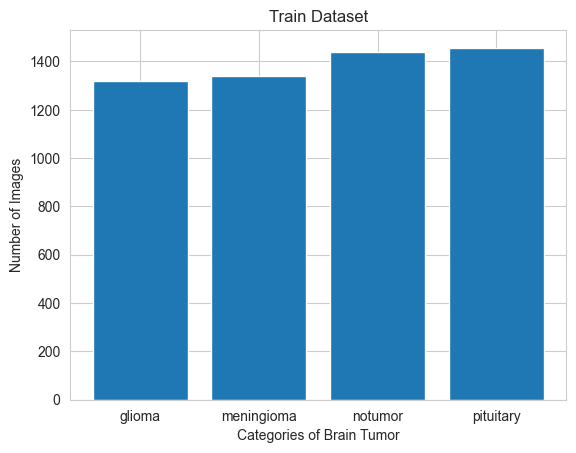

In [2]:
path1 = '/Brain tumor ml/dataset/Training'
subfolders1 = os.listdir(path1)
subfolder_counts1 = [len(os.listdir(os.path.join(path1, subfolder))) for subfolder in subfolders1]

x_labels = subfolders1
x = range(len(x_labels))
y = subfolder_counts1
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Categories of Brain Tumor')
plt.ylabel('Number of Images')
plt.title('Train Dataset')

plt.show()

31


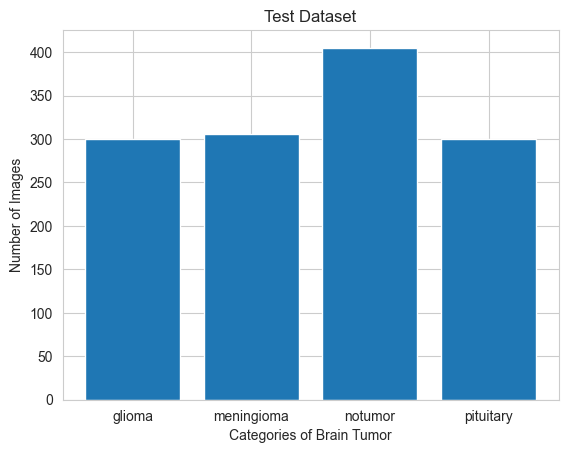

In [3]:
path2 = '/Brain tumor ml/dataset/Testing'
print(len(path2))
subfolders2 = os.listdir(path2)
subfolder_counts2 = [len(os.listdir(os.path.join(path2, subfolder))) for subfolder in subfolders2]

x_labels = subfolders2
x = range(len(x_labels))
y = subfolder_counts2
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Categories of Brain Tumor')
plt.ylabel('Number of Images')
plt.title('Test Dataset')
plt.show()

In [4]:
# Paths to training and testing datasets

train_dir = '/Brain tumor ml/dataset/Training'

test_dir = '/Brain tumor ml/dataset/Testing'

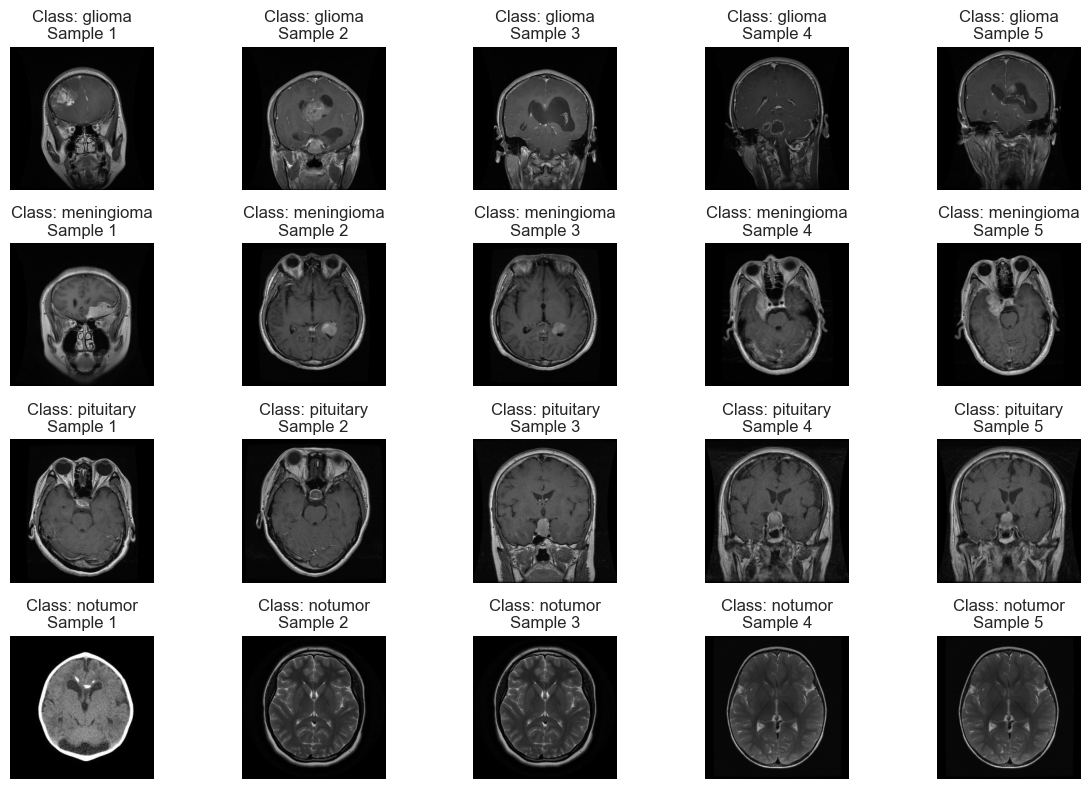

In [50]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# List of subdirectories representing different classes
class_folders = ['glioma', 'meningioma', 'pituitary', 'notumor']

plt.figure(figsize=(12, 8))

# Loop through each subdirectory and display sample images
for i, folder in enumerate(class_folders):
    sub_dir = os.path.join(train_dir, folder)
    sample_images = os.listdir(sub_dir)[:5]  # Load first 5 images from each subdirectory

    for j, image_name in enumerate(sample_images):
        img = Image.open(os.path.join(sub_dir, image_name))
        plt.subplot(4, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(f"Class: {folder}\nSample {j+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5557 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Processing Images & Feature extraction

In [43]:
#Finds the extreme points on the image and crops the rectangular out of them

def crop_img(path):
    img = cv2.imread(path)
#     plt.imshow(img)
#     plt.show()
#     print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     print(gray.shape)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 55, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    plt.imshow(new_img)
    plt.title("croped Image")
    plt.show()
    return new_img


"""
1. Finds the contours of the image
2. then extract the tumor contours
3. then extract the mean of area, perimeter, minor ans major axis of contour
"""
# the mean of all tumor contours   
def image_process_tumor_extraction(img): 
    dim=(500,590)
    img = cv2.resize(img, dim)
    img_tumor = img.copy()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print(gray_img.shape)
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    
    ret, thres_img = cv2.threshold(blur_img,100,255,cv2.THRESH_BINARY)
    
    titles = ['Original Image', 'Gray Scale','Blured Image', \
              'Threshold Image']
    images_phases = [img, gray_img,blur_img, thres_img]
    for i in range(len(images_phases)):
        plt.subplot(2,2,i+1),plt.imshow(images_phases[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
    contours, hierarchy = cv2.findContours(thres_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    full_contoured_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)

    
    # Select the contour(s) that correspond to the tumor
    tumor_contours = []
    tumor_contour_areas = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000 and area < 50000:
            tumor_contour_areas.append(area)
            tumor_contours.append(contour)
    tumor_contoured_img = cv2.drawContours(img_tumor, tumor_contours, -1, (255,255,0), 3)  
    
    titles_contour = ['Full Contour Image', 'Tumor Image']
    contour_images = [full_contoured_img, tumor_contoured_img ]
    for i in range(len(contour_images)):
        plt.subplot(1,2,i+1),plt.imshow(contour_images[i],'gray')
        plt.title(titles_contour[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

In [38]:
# manual cropped
file = 'E:/Brain tumor ml/processed images/1.PNG'
crop_file = 'E:/Brain tumor ml/processed images/2.PNG'

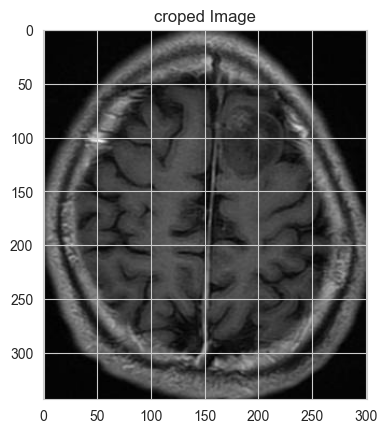

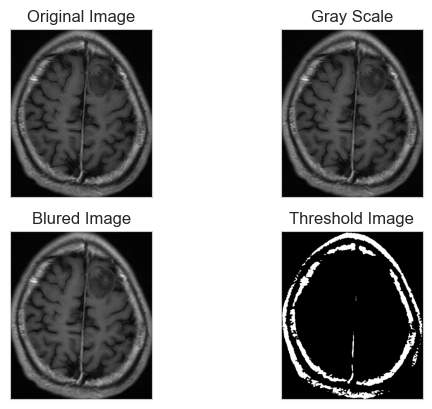

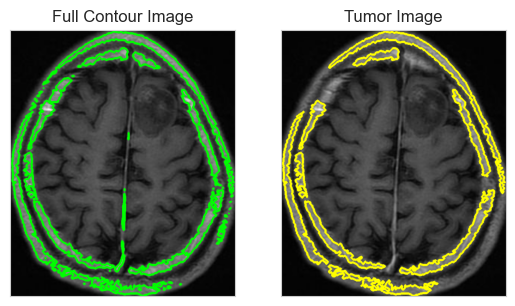

In [48]:
# glioma Tumor
import imutils
file1 = 'E:/Brain tumor ml/dataset/Training/glioma/Tr-gl_0057.jpg'
img = crop_img(file1)
image_process_tumor_extraction(img)

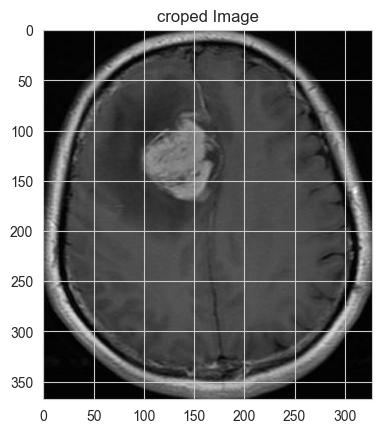

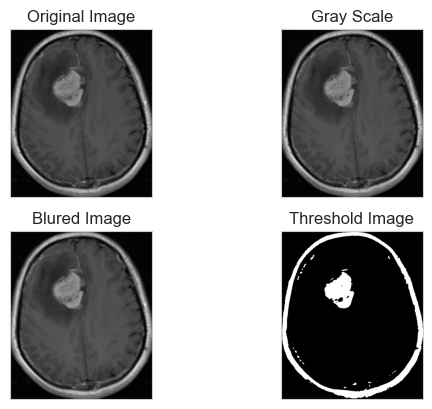

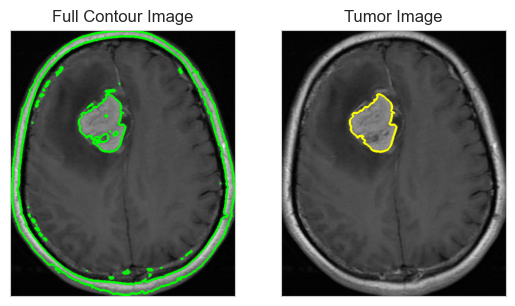

In [10]:
# meningioma Tumor
file2 = 'E:/Brain tumor ml/dataset/Training/meningioma/Tr-me_0016.jpg'

img = crop_img(file2)
image_process_tumor_extraction(img)

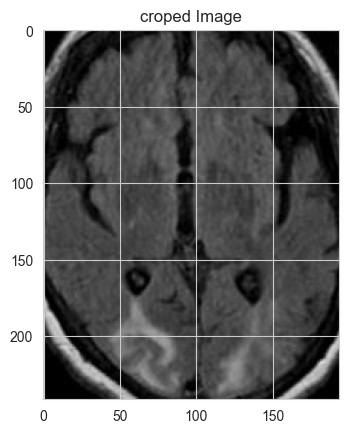

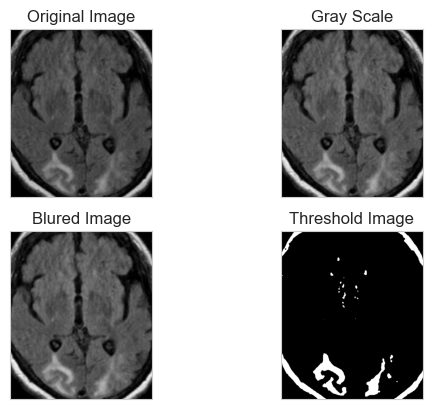

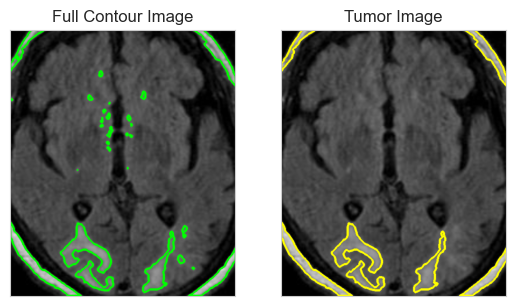

In [11]:
# No Tumor
file3 = 'E:/Brain tumor ml/dataset/Training/notumor/Tr-no_0043.jpg'
img = crop_img(file3)
image_process_tumor_extraction(img)

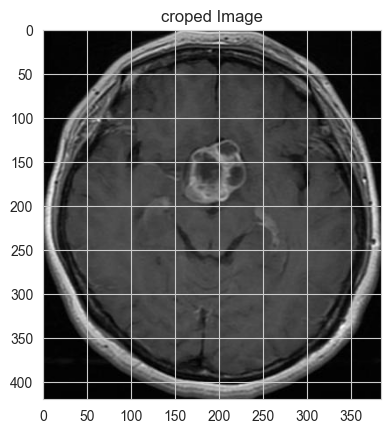

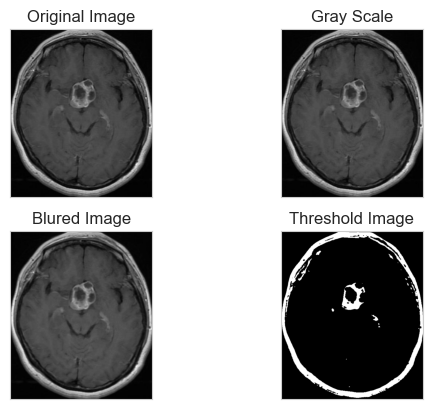

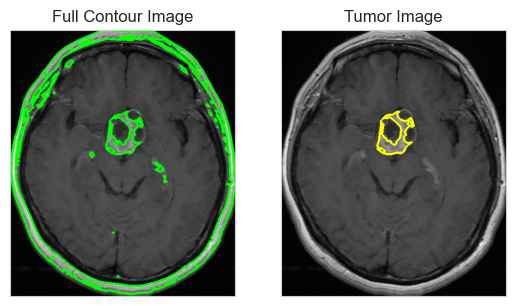

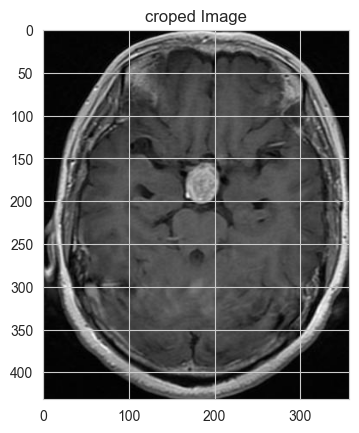

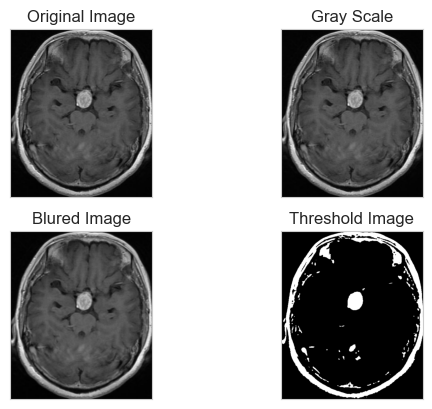

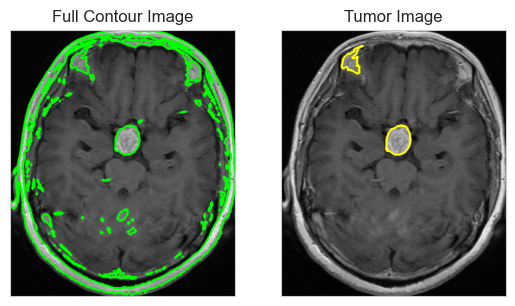

In [49]:
# pituitary Tumor
file4 = 'E:/Brain tumor ml/dataset/Training/pituitary/Tr-pi_0654.jpg'

img = crop_img(file4)
image_process_tumor_extraction(img)

file42 = 'E:/Brain tumor ml/dataset/Training/pituitary/Tr-pi_1022.jpg'
img = crop_img(file42)
image_process_tumor_extraction(img)

InceptionV3 Model

In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Define the model with InceptionV3 features
inception_model = Model(inputs=base_model.input, outputs=x)

In [14]:
train_features = inception_model.predict(train_generator)
test_features = inception_model.predict(test_generator)

41/41 [==============================] - 79s 2s/step


CNN

In [15]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Reshape

In [16]:
# Input layer for features
input_features = Input(shape=(2048,), name='input_features')

# Reshape features to match the expected input shape of the CNN model
reshaped_features = Reshape((32, 64, 1))(input_features)  # Adjust the dimensions based on your features

# CNN layers for feature extraction
cnn_output = Conv2D(32, (3, 3), activation='relu')(reshaped_features)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(32, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(64, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Flatten()(cnn_output)

cnn_output_reshaped = Reshape((1, -1))(cnn_output)

bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(cnn_output_reshaped)
bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(bi_lstm_output)

# Flatten the output of Bi-LSTM
bi_lstm_output_flatten = Flatten()(bi_lstm_output)

dense_layer = Dense(128, activation='relu')(bi_lstm_output_flatten)
dense_layer = Dropout(0.5)(dense_layer)
dense_layer = Dense(64, activation='relu')(dense_layer)
output = Dense(4, activation='softmax')(dense_layer)

cnn_model = Model(inputs=input_features, outputs=output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 2048)]            0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 32, 64, 1)         0         
                                                                 
 conv2d_94 (Conv2D)          (None, 30, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 13, 29, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 14, 32)         0  

In [17]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Convert integer labels to one-hot encoding
train_labels_one_hot = to_categorical(train_generator.classes, num_classes=4)
test_labels_one_hot = to_categorical(test_generator.classes, num_classes=4)

In [18]:
history_cnn = cnn_model.fit(
    train_features,
    train_labels_one_hot,
    validation_data=(test_features, test_labels_one_hot),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


174/174 [==============================] - 22s 50ms/step - loss: 1.2290 - accuracy: 0.3995 - val_loss: 0.8649 - val_accuracy: 0.6316
Epoch 2/50
174/174 [==============================] - 6s 37ms/step - loss: 0.7724 - accuracy: 0.6833 - val_loss: 0.6546 - val_accuracy: 0.7490
Epoch 3/50
174/174 [==============================] - 6s 36ms/step - loss: 0.6026 - accuracy: 0.7590 - val_loss: 0.5578 - val_accuracy: 0.7735
Epoch 4/50
174/174 [==============================] - 6s 36ms/step - loss: 0.4907 - accuracy: 0.8112 - val_loss: 0.5458 - val_accuracy: 0.7788
Epoch 5/50
174/174 [==============================] - 6s 37ms/step - loss: 0.4203 - accuracy: 0.8456 - val_loss: 0.5625 - val_accuracy: 0.7948
Epoch 6/50
174/174 [==============================] - 6s 36ms/step - loss: 0.3573 - accuracy: 0.8712 - val_loss: 0.5332 - val_accuracy: 0.7933
Epoch 7/50
174/174 [==============================] - 6s 36ms/step - loss: 0.2926 - accuracy: 0.8960 - val_loss: 0.6404 - val_accuracy: 0.7

ROC Curve

41/41 [==============================] - 1s 12ms/step - loss: 0.5332 - accuracy: 0.7933
Test accuracy: 0.7932875752449036
41/41 [==============================] - 4s 12ms/step


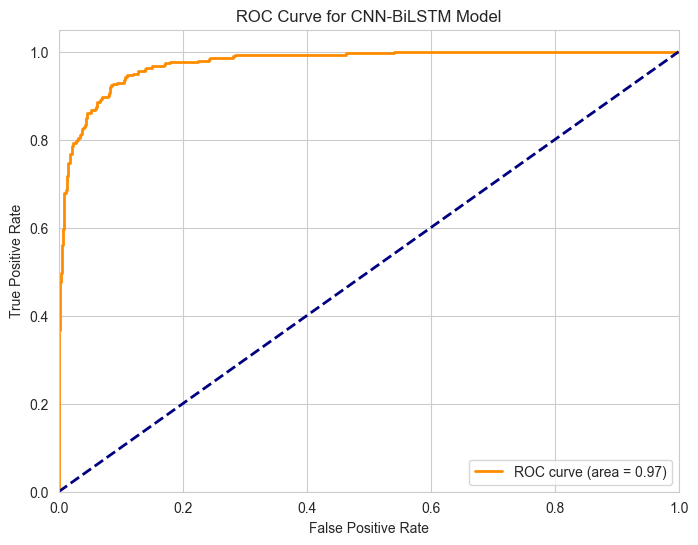

In [19]:
# Evaluate the model on the test data
test_loss, test_acc = cnn_model.evaluate(test_features, test_labels_one_hot)
print('Test accuracy:', test_acc)

# Get predictions for the test data
predictions = cnn_model.predict(test_features)

# From predictions, get probabilities for the positive class (assuming 4 classes)
predicted_proba = predictions[:, 3]  # Assuming the positive class is at index 3

# Import libraries for ROC curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels_one_hot[:, 3], predicted_proba)  # Assuming labels are one-hot encoded
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN-BiLSTM Model')
plt.legend(loc="lower right")
plt.show() 

In [45]:
# save model and architecture to single file
cnn_model.save("CNN_Model.h5")
print("Saved model to disk")

Saved model to disk


Hyperparameter Tuning

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, Bidirectional, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [22]:
# Define your model architecture
def build_model(hp):
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=1e-3)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=1e-3)
    else:
        optimizer = SGD(learning_rate=1e-3)
    dense_layer = Dense(dense_units, activation='relu')(bi_lstm_output_flatten)
    dense_layer = Dropout(dropout_rate)(dense_layer)
    dense_layer = Dense(64, activation='relu')(dense_layer)
    output = Dense(4, activation='softmax')(dense_layer)

    model = Model(inputs=input_features, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
# Create tuner and perform hyperparameter
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='hyperparameter_tuning',
    project_name='cnn_model_tuning'
)

# Assuming you already have train_features, test_features, train_labels_one_hot, and test_labels_one_hot
tuner.search(
    train_features, 
    train_labels_one_hot, 
    epochs=50,
    validation_data=(test_features, test_labels_one_hot),
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 01m 30s]
val_accuracy: 0.8291380405426025

Best val_accuracy So Far: 0.8291380405426025
Total elapsed time: 00h 11m 17s


In [24]:
# Plot the architecture of the best model
best_model = tuner.get_best_models(1)[0]


# Extract information about the best trials
best_trials = tuner.oracle.get_best_trials(5)
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 2048)]            0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 32, 64, 1)         0         
                                                                 
 conv2d_94 (Conv2D)          (None, 30, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 13, 29, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 14, 32)         0     

In [46]:
# save model and architecture to single file
best_model.save("best_Tuning.h5")
print("Saved model to disk")

Saved model to disk


Hyperparameter Search

In [31]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Bidirectional, GRU, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

In [32]:
# Define your model architecture
def build_model(hp):
    model = Sequential()

    input_features = Input(shape=(2048,), name='input_features')
    reshaped_features = Reshape((32, 64, 1))(input_features)

    
    # Bi-GRU layers with dropout
    for _ in range(hp.Int('num_bigru_layers', min_value=1, max_value=3, step=1)):
        model.add(Bidirectional(GRU(units=hp.Int('bigru_units', min_value=32, max_value=128, step=32),
                                     return_sequences=True, dropout=hp.Float('bigru_dropout', min_value=0.2, max_value=0.5, step=0.1))))
        model.add(Dropout(hp.Float('bigru_dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Flatten the output of Bi-GRU
    bi_gru_output_flatten = Flatten()(reshaped_features)

    dense_layer = Dense(128, activation='relu', kernel_regularizer=l2(hp.Float('kernel_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')))(bi_gru_output_flatten)
    dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(hp.Float('kernel_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')))(dense_layer)
    output = Dense(4, activation='softmax')(dense_layer)

    model1 = Model(inputs=input_features, outputs=output)

    # Choose an optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=1e-3)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=1e-3)
    else:
        optimizer = SGD(learning_rate=1e-3)

    model1.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model1

In [35]:
#Create tuner and perform hyperparameter search
tuner_ = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='hyperparameter_tuning1',
    project_name='cnn_model_tuning'
)

tuner_.search(train_features, train_labels_one_hot,batch_size=32, epochs=10, validation_data=(test_features, test_labels_one_hot))

Trial 10 Complete [00h 00m 15s]
val_accuracy: 0.893211305141449

Best val_accuracy So Far: 0.8985507488250732
Total elapsed time: 00h 02m 20s


In [36]:
# Plot the architecture of the best model
best_model1 = tuner_.get_best_models(1)[0]


# Extract information about the best trials
best_trials = tuner.oracle.get_best_trials(5)
best_model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 2048)]            0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 32, 64, 1)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                             

In [47]:
# save model and architecture to single file
best_model1.save("best_search.h5")
print("Saved model to disk")

Saved model to disk


Ensemble Method